In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load and Merge Datasets


# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
# Merge datasets for clustering
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

In [4]:
# Feature Engineering

customer_features = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',                      # Total quantity purchased
    'TotalValue': 'sum',                    # Total revenue generated
    'ProductID': 'nunique',                 # Number of unique products purchased
    'Category': 'nunique'                   # Number of unique product categories
}).reset_index()

In [5]:
# Add profile features from the customers dataset
customer_profiles = customers[['CustomerID', 'Region']]
customer_features = customer_features.merge(customer_profiles, on="CustomerID", how="left")

In [6]:
# One-hot encode the 'Region' feature
customer_features = pd.get_dummies(customer_features, columns=['Region'])

In [7]:
# Normalize the Data

scaler = StandardScaler()
numerical_columns = ['Quantity', 'TotalValue', 'ProductID', 'Category']
customer_features[numerical_columns] = scaler.fit_transform(customer_features[numerical_columns])

In [8]:
# Extract features for clustering
X = customer_features.drop(columns=['CustomerID']).values

In [9]:
# Perform Clustering



db_indices = []
silhouette_scores = []

In [10]:
# Test clustering with K = 2 to 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(X, labels)
    silhouette = silhouette_score(X, labels)
    
    db_indices.append(db_index)
    silhouette_scores.append(silhouette)


optimal_k = 2 + np.argmin(db_indices)  
print(f"Optimal number of clusters: {optimal_k}")


Optimal number of clusters: 2


In [11]:
# Final clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X)

In [12]:
# Evaluate Clustering


# Davies-Bouldin Index and Silhouette Score for optimal clustering
final_db_index = davies_bouldin_score(X, customer_features['Cluster'])
final_silhouette = silhouette_score(X, customer_features['Cluster'])

print(f"Davies-Bouldin Index: {final_db_index}")
print(f"Silhouette Score: {final_silhouette}")

Davies-Bouldin Index: 1.0518992341748352
Silhouette Score: 0.35320932149065964


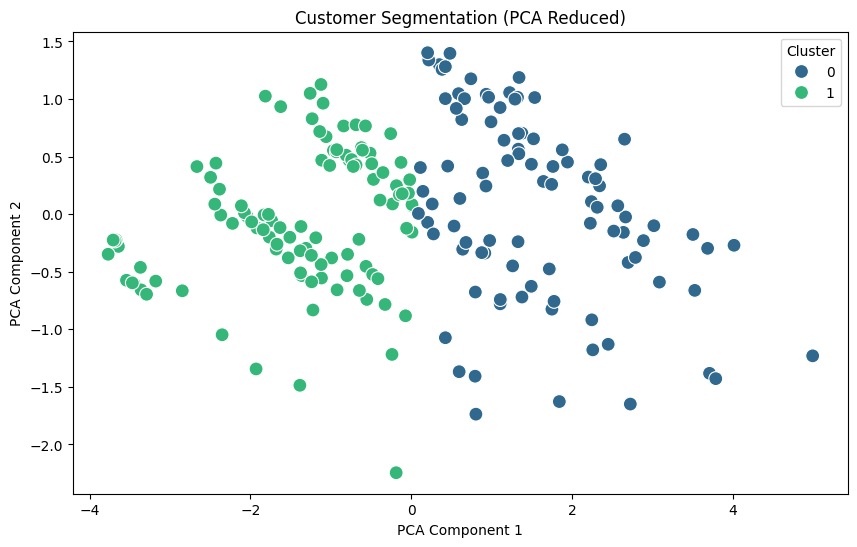

In [13]:
# Visualize Clusters

# Reduce dimensions using PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Add PCA components to the customer features for plotting
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Cluster', data=customer_features, 
    palette='viridis', s=100
)
plt.title("Customer Segmentation (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


In [14]:
# Save Results


customer_features[['CustomerID', 'Cluster']].to_csv("FirstName_LastName_Clustering.csv", index=False)

In [15]:

with open("FirstName_LastName_Clustering_Summary.txt", "w") as f:
    f.write("Customer Segmentation Results\n")
    f.write(f"Optimal Number of Clusters: {optimal_k}\n")
    f.write(f"Davies-Bouldin Index: {final_db_index:.2f}\n")
    f.write(f"Silhouette Score: {final_silhouette:.2f}\n")

print("\nClustering results saved as 'FirstName_LastName_Clustering.csv'.")
print("Clustering summary saved as 'FirstName_LastName_Clustering_Summary.txt'.")


Clustering results saved as 'FirstName_LastName_Clustering.csv'.
Clustering summary saved as 'FirstName_LastName_Clustering_Summary.txt'.
